# Adaptive bandwidth KDE


## A motivational example

In this motivational example we get data points from a mixture of two Gaussian distributions with different spread and location. One of the distributions has very low variability, while the other is more scattered. The resulting distribution is 

$$
\frac{1}{2} N(0, \frac{1}{5}) + \frac{1}{2} N(5, 1) 
$$

In order to evaluate the association between the sample size and the performance of the estimators we repeat the process for different values of $n$. The steps are summarized as follows:

For $n$ in $[200, 500, 1000, 5000]$:
1. Obtain a sample of size $n$ from the theoretical distribution.
1. Estimate the bandwidth via both Improved Sheather Jones and Silverman's rule.
1. Estimate the density via the Gaussian KDE using both estimates of $h$.
1. Plot the theoretical density and overlay the two estimates on top of it.

In [45]:
import sys
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams['figure.figsize'] = [10, 7]
sys.path.append('../src/')
from my_functions import convolution_kde, h_isj, h_sil

# Colors
BLUE = "#3498db"
DARK_BLUE = "#2980b9"
NIGHT_BLUE = "#2c3e50"
DARK_RED = "#c0392b"
LIGHT_BLUE = "#56B4E9"
LIGHT_GRAY = "#474747"

def generate_rvs(n, mean, sd, wt=None):
    if wt is None:
        wt = np.repeat((1 / len(mean)), len(mean))
    assert len(mean) == len(sd) == len(wt)
    assert np.sum(wt) == 1
    x = np.concatenate((
        list(map(lambda m, s, w: stats.norm.rvs(m, s, int(np.round(n * w))), mean, sd, wt))
    ))
    return x

def get_pdf(x_grid, mean, sd, wt=None):
    if wt is None:
        wt = np.repeat((1 / len(mean)), len(mean))
    assert len(mean) == len(sd) == len(wt)
    assert np.sum(wt) == 1
    pdf = np.average(list((map(lambda m, s: stats.norm.pdf(x_grid, m, s), mean, sd))), axis=0, weights=wt)
    return pdf

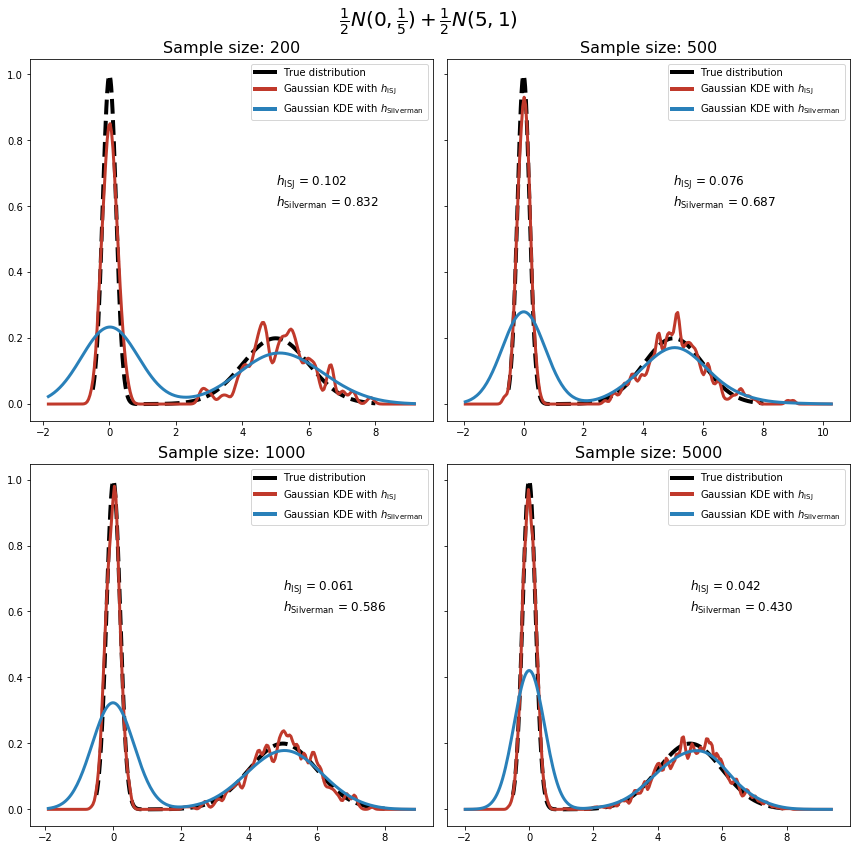

In [2]:
mean = [0, 5]
sd = [0.2, 1]
sizes = [200, 500, 1000, 5000]
x_grid = np.linspace(-0.5, 8, 1000)

pdf_true = get_pdf(x_grid, mean, sd)

# Plot
fig, axes = plt.subplots(2, 2, figsize = (12, 12), sharey=True)

colors = ["black", DARK_RED, DARK_BLUE]
labels = ["True distribution", r"Gaussian KDE with $h_{\mathrm{ISJ}}$", "Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

for n, i, j in zip(sizes, [0, 0, 1, 1], [0, 1, 0, 1]):

    rvs = generate_rvs(n, mean, sd)
    hisj = h_isj(rvs)
    hsil = h_sil(rvs)
    x1, y1 = convolution_kde(rvs, h=hisj)
    x2, y2 = convolution_kde(rvs, h=hsil)
    
    annotation_string = r"$h_{\mathrm{ISJ}}$ = %.3f" % (hisj)
    annotation_string += "\n"
    annotation_string += r"$h_{\mathrm{Silverman}}$ = %.3f" % (hsil)
    
    axes[i, j].plot(x_grid, pdf_true, color="black", linewidth="4", linestyle="--")
    axes[i, j].plot(x1, y1, color=DARK_RED, linewidth=3)
    axes[i, j].plot(x2, y2, color=DARK_BLUE, linewidth=3)
    axes[i, j].set_title('Sample size: ' + str(n), size=16)
    axes[i, j].text(5, 0.6, annotation_string, size = 12)
    axes[i, j].legend(lines, labels);

fig.suptitle(r"$ \frac{1}{2} N(0, \frac{1}{5}) + \frac{1}{2} N(5, 1) $", fontsize=20)
plt.tight_layout()
fig.subplots_adjust(top=0.92)

We can make several comments as we observe the plot:
* In this particular case, $h_{\text{ISJ}}$ and $h_{\text{Silverman}}$ estimations are never similar. Indeed, $h_{\text{ISJ}}$ is around one tenth of $h_{\text{Silverman}}$.
* $h_{\text{ISJ}}$ produces an estimate that captures very well the shape around the tallest and most narrow peak. However, it also introduces a lot of unnecesary noise around the second mode.
* $h_{\text{Silverman}}$ fails in a different manner. It does a good job the shape around the second mode but oversmooths around the mode on the left.
* None of the estimators produce a satisfactory result even with large sample sizes.

## Introduction

The classic kernel density estimator we have introduced in previous notebooks implies the standard deviation of each of the kernels is constant. Whether the estimator does a good job or fail (undersmoothing or oversmoothing) will depend on the shape of $f$ and the method used to estimate the bandwidth $h$. 

As seen in the motivational example, if the true $f$ has tall peaks and/or multimodalities the Improved Sheather-Jones method will be surely able to capture them appropiately. However, it will introduce unnecesary noise in more stable regions of the density. On the other hand, if we use a more conservative method for these kind of densities, like the Silverman's rule of thumb, the estimate will not present wiggly regions, at the cost of an oversmoothed density.

While this problem also appears in unimodal and skewed distributions, it is not too harmful if the skewness is not extreme.

A useful and natural alternative is to use a variable $h$, one that depends on the local density of the input data points. This concept is known as adaptive or variable KDE. In regions with higher density the bandwidth is decreased, and in regions with lower density the bandwidth is increased.

Two popular alternatives in the literature are the balloon and the sample point estimators. The first one suffers from a number of drawbacks, like not integrating to one over the entire domain. The second uses a different bandwidth for each data point $X_i$ and results in a true density. Both of these alternatives alter each kernel's bandwidth, but they don't modify the weight they are assigned (i.e. we still have a simple average of kernels).

A more flexible approach arises when we consider a kernel density estimator where both the bandwidth and the weight assigned to each kernel are variable. Instead of having a simple average of $N$ Gaussian kernels with common standard deviation $h$, we will have a weighted average of Gaussian kernels with variable standard deviation $h(X_i)$. In this notebook we are going to implement this via the Expectation-Maximization algorithm.

## Sample point estimator

While the classic kernel density estimator uses a constant bandwidth $h$ for every kernel centeread at each data point $X_i$, the sample point estimator uses a variable bandwidth. The estimate of $f$ at every $x$ is then an *average of differently scaled kernels* centered at each data point $X_i$. The estimator is defined as follows:

$$
\displaystyle \hat{f}_{SP}(x; h(X_i)) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{h(X_i)}\kappa\left( \frac{x - X_i}{h(X_i)}\right)}
\tag{4.1}
$$

Now we have a $h(X_i)$ that depends on the sample point $X_i$. The following is one of the possible approaches to calculate the adjustment factor and consequently the sample point estimator.

1. Calculate $\hat{f}(x, h)$ as usual. The bandwidth can be estimated by any of the methods presented. We call the resulting $\hat{f}$ a pilot estimate.
2. Determine the modification parameters $s_i$, $i = 1, \cdots, n$ as 
$$
s_i = \left(\frac{\hat{f}(X_i, h)}{T}\right) ^ {-c}
\tag{4.2}
$$

where $c \ge 0$ and $T$ is the geometric mean of the pilot density estimate at all the sample points, $\hat{f}(X_1, h)$, $\hat{f}(X_2, h)$, $\cdots$, $\hat{f}(X_N, h)$

$$
T = \exp{\left(\frac{1}{N} \sum_{i=1}^{N}{\ln{\hat{f}(X_i, h)}} \right)}
\tag{4.3}
$$

3. Finally, the sample point estimator is

$$
\hat{f}(x, h) = \frac{1}{Nh} \sum_{i=1}^{N}{\frac{1}{s_i}\kappa\left(\frac{x - X_i}{hs_i} \right)}
\tag{4.4}
$$

In the case that the Gaussian kernel is used, the sample point estimator results in 

$$
\hat{f}(x;h) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}hs_i}e^{-\frac{1}{2}\left(\frac{x - X_i}{hs_i}\right)^2}}
\tag{4.5}
$$

It is not difficult to see the resulting estimator is a simple average of Gaussian distributions centered at each $X_i$ with a standard deviation $hs_i$ specific to each data point.

**Remarks**

* If $c=0$ or $\hat{f}(X_i, h) = T$ then $s_i=1$ and the sample point estimator is equal to the usual constant bandwidth KDE.  
* If $\hat{f}(X_i, h)$ is smaller than the geometric mean of $\hat{f}(\cdot, h)$ then $s_i \gt 1$ and the kernel centered at $X_i$ is stretched out.
* In the opposite case, when $s_i \lt 1$ the kernel centered at $X_i$ is narrowed.

In practice the parameter $c$ can be initially set to 0.5. It can be seen as a parameter that controls how much to adjust the bandwidth. Larger values are related to more strong bandwidth modifications.

<!-- Question: Why do we use geometric mean? -->

In [2]:
def gaussian_kde_adap(x, h=None, grid_len=256, extend=True):
    """
    Sample Point adaptive Gaussian KDE.
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses Gaussian robust rule of thumb.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to 256.
    extend: boolean, optional
        Whether to extend the domain of the observed data or not. 
        Defaults to True.

    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    """
    
    x_len = len(x)
    
    if h is None:
        s = min(np.std(x), stats.iqr(x) / 1.34)
        h = 0.9 * s * x_len ** (-0.2)
    
    # Step 1: Calculate \hat{f} as usual.
    grid, pdf = convolution_kde(x=x, h=h, grid_len=grid_len, extend=extend)
    
    # Step 2: Determine the modification factors.
    # 2a: Geometric mean of KDE evaluated at sample points.
    pdf_interp = np.interp(x, grid, pdf) # (2)
    pdf_interp_geom_mean = np.exp(np.mean(np.log(pdf_interp))) # (1)
    
    # 2b: Compute modification factors.
    c = 0.5
    adj_factor = (pdf_interp_geom_mean / pdf_interp) ** c
    h_adjusted = h * adj_factor
    
    pdf_mat = np.exp(-0.5 * ((grid - x[:, None]) / h_adjusted[:, None]) ** 2) / ((2 * np.pi) ** 0.5 * h_adjusted[:, None])
    pdf = np.mean(pdf_mat, axis=0)

    return grid, pdf, h_adjusted

# (1) scipy.gmean is an alternative but the time speedup is only within 5%.
#     It takes 2.8e-4 secs for 100k array, then, there's not significal speedup in practice.

# (2) Theoretically we compute the geometric mean using f(X_i, h), and this requires interpolation.
#     An alternative for the computation of the geometric mean would be using the x grid values and
#     the results should be similar. 

## Illustrative toy example

No matter we have repeated several times the classic Gaussian KDE is just a simple average of Gaussian distributions centered at the observed data points, now we are going to present it in an illustrative manner. Next, we present the Sample Point KDE in the same fashion. This lets us observe the difference between the kernels used in each case.

The data is just a set of $n=6$ values constructed specifically for this example. Because of a scaling issue we multiply each of the points by their corresponding weight, $1/6$. In both plots it is straightforward to note that the final estimation in blue is the summation of the individual kernels.

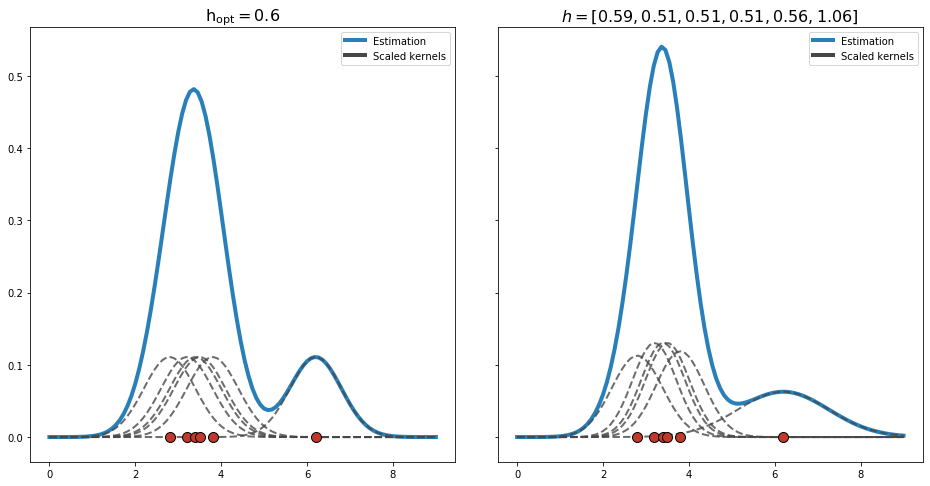

In [3]:
# Helper function to be used in title
def convert(list): 
    s = [str(i) for i in list]  
    res = ", ".join(s)
    return res 

# Data
rvs = np.array([2.8, 3.2, 3.4, 3.5, 3.8, 6.2])
h_opt =  0.6
h_ada = np.array([0.59, 0.51, 0.51, 0.51, 0.56, 1.06])
x_grid = np.linspace(0, 9, 100)

# "Optimal" bandwidth kernels
kernels_opt = np.transpose([stats.norm.pdf(x_grid, m, h_opt) for m in rvs]) / len(rvs)
pdf_opt = np.sum(kernels_opt, axis=1)

# Adaptative bandwidth kernels
kernels_ada = np.transpose([stats.norm.pdf(x_grid, m, s) for m, s in zip(rvs, h_ada)]) / len(rvs)
pdf_ada = np.sum(kernels_ada, axis=1)

# Plot
colors = [DARK_BLUE, LIGHT_GRAY]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["Estimation", "Scaled kernels"]

fig, axes = plt.subplots(1, 2, figsize = (16, 8), sharey=True)

axes[0].plot(x_grid, pdf_opt, linewidth=4, color=DARK_BLUE, zorder=1)
axes[0].plot(x_grid, kernels_opt, linewidth = 2, linestyle="--", color=LIGHT_GRAY, alpha=0.8, zorder=2)
axes[0].scatter(rvs, np.zeros(len(rvs)), s=100, color=DARK_RED, edgecolor='black', zorder=3)
axes[0].set_title(r"$\mathrm{h_{opt}} = 0.6$", size=16)
axes[0].legend(lines, labels);

axes[1].plot(x_grid, pdf_ada, linewidth=4, color=DARK_BLUE, zorder=1)
axes[1].plot(x_grid, kernels_ada, linewidth = 2, linestyle="--", color=LIGHT_GRAY, alpha=0.8, zorder=2)
axes[1].scatter(rvs, np.zeros(len(rvs)), s=100, color=DARK_RED, edgecolor='black', zorder=3)
axes[1].set_title(r"$ h = [{vals}]$".format(vals=convert(h_ada)), size=16)
axes[1].legend(lines, labels)

plt.subplots_adjust(wspace=0.1)

Now we can easily see the effect of the scaling factor in the sample point estimator. While all the kernels on the left plot are identical in terms of spread, the kernels on the right plot differ. The scaling factor narrows the kernels placed at points where there is high density and stretches out the kernels in sparse regions. Consequently, the importance of the point around 6 diminishes.

## Sample Point estimator in action

We show three extra examples to better understand how the sample point estimator behaves in different scenarios.

In [4]:
# Helper functions to be used
def plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2):
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 8), sharey=True)

    axes[0].plot(x_grid, pdf_true, color="black", linewidth=4, linestyle="--", label="True")
    axes[0].plot(x1, y1, color=DARK_BLUE, linewidth=4, label="Estimation")
    axes[0].scatter(rvs, np.zeros(n), s=100, color=DARK_RED, edgecolor='black', alpha=0.6)
    axes[0].set_title("Constant bandwidth estimator", size=16)
    axes[0].legend();

    axes[1].plot(x_grid, pdf_true, color="black", linewidth=4, linestyle="--", label="True")
    axes[1].plot(x2, y2, color=DARK_BLUE, linewidth=4, label="Estimation")
    axes[1].scatter(rvs, np.zeros(n), s=100, color=DARK_RED, edgecolor='black', alpha=0.6)
    axes[1].set_title("Sample point estimator", size=16)
    axes[1].legend();
    
    plt.subplots_adjust(wspace=0.1)

### Gaussian distribution

A correct estimation of a simple Gaussian distribution is the minimum we can require from a density estimator. In this case the proposed estimator differs very little from the classic Gaussian KDE. In addition, it smooths out some bumps that appear because of the small sample size. The latter could be an improvement or not depending on the context and taste of the practitioner.

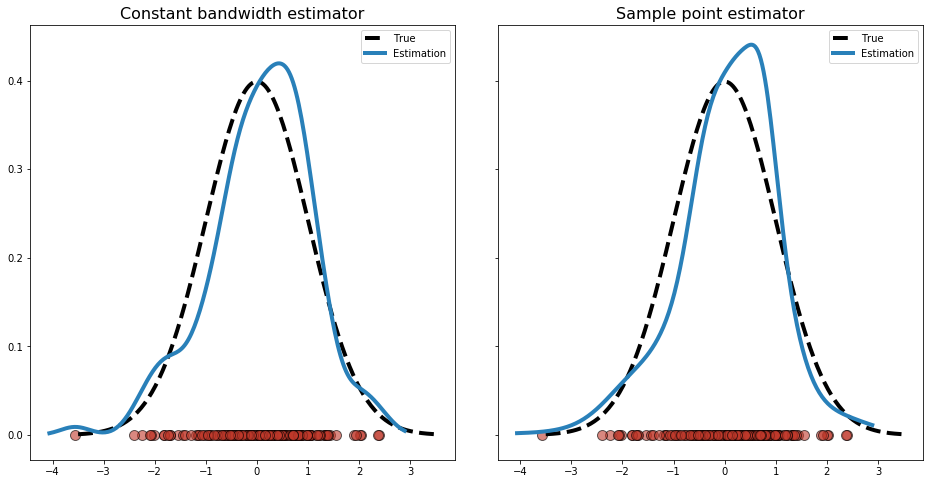

In [5]:
np.random.seed(1234)
n = 150
x_grid = np.linspace(-3.5, 3.5, num=200)

rvs = generate_rvs(n, [0], [1], [1])
pdf_true = get_pdf(x_grid, [0], [1], [1])

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

### Bimodal distribution 1

This example is similar to the motivational case we presented in the very beginning. However, the separation between the two modes and the difference in their spread is not that severe. It turns out to be a nice example where the classic Gaussian KDE does not fail badly, but the Sample Point estimator improves the estimation substantially (even with the used sample size of $n=150$).

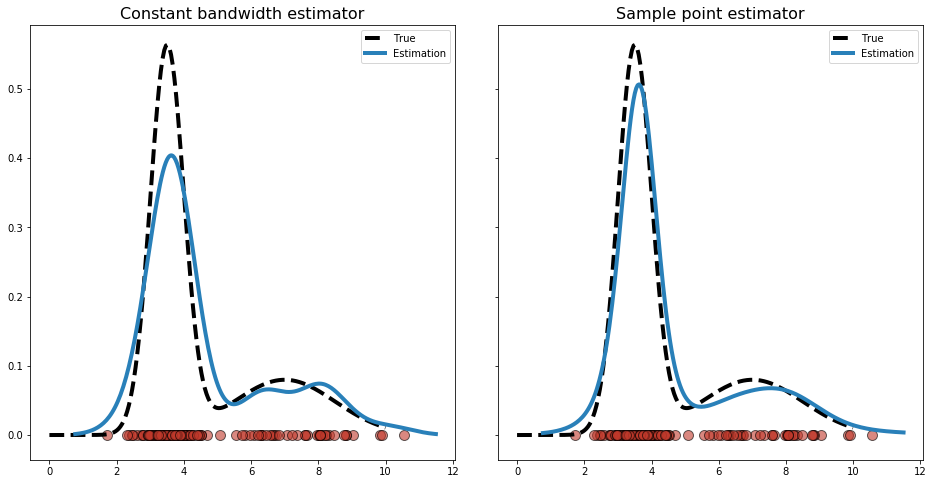

In [6]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 7]
sd = [0.5, 1.5]
wt = [0.70, 0.30]
n = 150

rvs = generate_rvs(n, mean, sd, wt)
pdf_true = get_pdf(x_grid, mean, sd, wt)

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

### Bimodal distribution 2

Now we increase the separation between the two modes and note that none of the estimators is completely convincent. The sample point estimator mitigates a little the exaggerated oversmoothness of the classic KDE, but it is not enough.  
The adaptive characteristic of the sample point estimator is associated with an improvement in the estimation, but it is not a magical device.

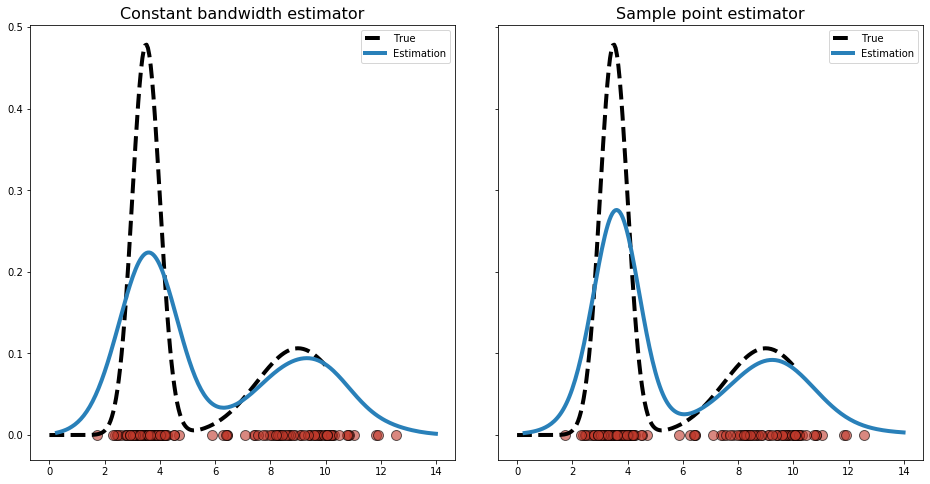

In [7]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 9]
sd = [0.5, 1.5]
wt = [0.6, 0.4]
n = 150

rvs = generate_rvs(n, mean, sd, wt)
pdf_true = get_pdf(x_grid, mean, sd, wt)

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

### Asymmetric distribution

We leave Gaussian mixtures for a moment and see whether there is any improvement when the distribution is right-skewed like a the following Lognormal distribution. Even though the estimation provided by the classic Gaussian KDE is more or less decent, the sample point estimator improves its performance. For example, we see that spurious bumps in the tail of the distribution are mitigated and the estimated and the true mode are closer.

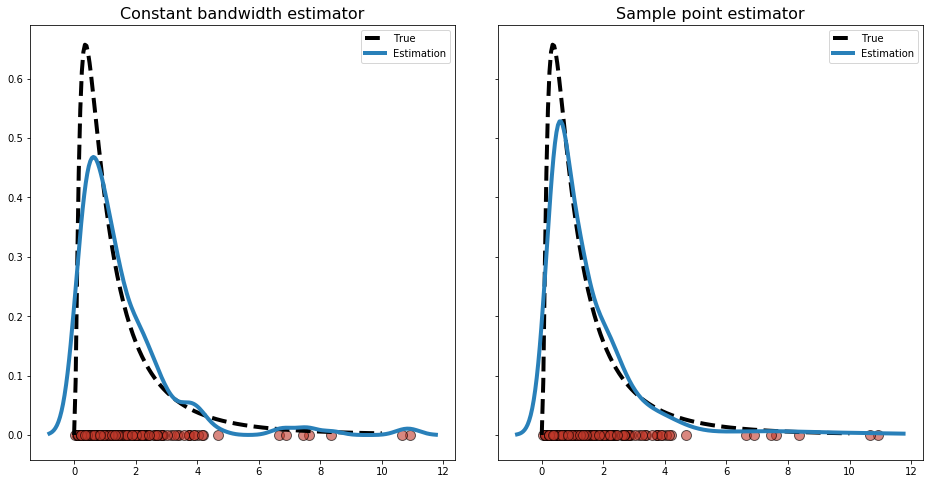

In [68]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
n = 200

rvs = stats.lognorm.rvs(s=1, size=n)
pdf_true = stats.lognorm.pdf(x_grid, s=1)

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

## Expectation-Maximization as a density estimator

A more general way to describe the Gaussian kernel density estimator is via a Gaussian mixture model.

$$
f(x | \theta) = \sum_{j=1}^J{p_j \phi(x | \mu_j, \sigma_j)}
\tag{4.6}
$$

where

$$
\phi(x | \mu_j, \sigma_j) = \frac{1}{\sqrt{2\pi} \sigma_j} e^{-\frac{1}{2}\left(\frac{x - \mu_j}{\sigma_j} \right)^2}
\tag{4.7}
$$

and $\theta = (\theta_1, \cdots, \theta_J) = ((p_1, \mu_1, \sigma_1), \cdots, (p_J, \mu_J, \sigma_J))$  is a vector containing the mixing probabilities $p_j$ as well as the means $\mu_j$ and standard deviations of the $J$ Gaussian functions in the mixture. In the case of the classic Gaussian KDE we have $p_j = 1/N$, $\mu_j = X_j$, and $\sigma_j = h$ for all $j=1, \cdots, N$.

To ensure $f$ is a bona fide probability density function the mixing probabilities must be non-negative and add up to 1.

$$
\vdots
$$

$$
\vdots
$$

**Introduce the estimation problem** (I must check notes at home).

**Some helpful notes to include in text**

Mixture advantages:
* More degrees of freedom (parameers) than parametric estimates $\implies$ less bias.
* Much smaller number of comopnents than kernel estimates $\implies$ less parameters, less variance.
* For the mixture we can learn both means and variances from the data (and any other parameters)
* This usually leads to better fit.

Mixture disadvantages
* Learning complexity: There is usually no closed form solution and then one needs to use numerical procedures
* A stanard tool is the Expectation-Maximization algorithm

**Algorithm 4.1:** EM Algorithm for K-component Gaussian Mixture.

**1.** Take initial guesses for the parameters $\mathbb{\hat{\mu}} = (\hat{\mu}_1, \cdots, \hat{\mu}_J)$, $\mathbb{\hat{\sigma}^2} = (\hat{\sigma}^2_1, \cdots, \hat{\sigma}^2_J)$ and $\hat{\textbf{p}} = (\hat{p}_1, \cdots, \hat{p}_J)$. They conform the vector of parameters $\theta_{old}$.

**2.** *Expectation Step:* Compute the responsabilities

$$
\gamma_{j,i}(\theta_{old}) = P(Z_i =j | X_i = x_i, \theta_{old}) = \frac{P(Z_i = j, X_i = x_i | \theta_{old})}{P(X_i = x_i | \theta_{old})}
$$

the right side could be further decomposed using Bayes' theorem
$$
\gamma_{j,i}(\theta_{old}) = \frac{f_{X|Z}(x_i |Z_i = j, \theta_{old}) P(Z_i = j | \theta_{old})}{\sum_{k=1}^J{f_{X|Z}(x_i |Z_i = k, \theta_{old}) P(Z_i = k | \theta_{old})}}
$$

where $X$ is the observed variable and $Z$ is a latent variable indicating from which Gaussian component each $y_i$ comes from.

**3.** *Maximization Step:* compute the weigted means and variances as well as the mixing probabilities

$$
\mu_{j, new} = \frac{\sum_{i=1}^N {\gamma_{j,i}(\theta_{old}) x_i }}{\sum_{i=1}^N {\gamma_{j,i}(\theta_{old})}}
$$

$$
\sigma^2_{j, new} = \frac{\sum_{i=1}^N {\gamma_{j,i}(\theta_{old}) (x_i - \mu_j)^2 }}{\sum_{i=1}^N {\gamma_{j,i}(\theta_{old})}}
$$

$$
p_{j, new} = \frac{1}{N}\sum_{i=1}^N {\gamma_{j,i}(\theta_{old})}
$$

**4.** Repeat 2 and 3, setting $\theta_{old} = \theta_{new}$ after each cycle, until the estimates converge. 

**Note:** $\displaystyle \sum_{j=1}^J{\sum_{i=1}^N {\gamma_{j,i}}} = N$

In [93]:
def _get_mixture(grid, mu, var, weight):
    out = np.sum(list((map(lambda m, v, w: _norm_pdf(grid, m, v, w), mu, var, weight))), axis=0)
    return out

def _norm_pdf(grid, mu, var, weight):
    # 1 / np.sqrt(2 * np.pi) = 0.3989423
    out = np.exp(-0.5 * ((grid - mu)) ** 2 / var) * 0.3989423 * (var ** -0.50) * weight
    return out   

def em_kde(x, gauss_n=None, grid_len=None, extend=True, iter_max=200, tol=0.005, verbose=False):
    
    """
    Adaptative Gaussian KDE by E-M algorithm.
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    gauss_n : float, optional
        Number of Gaussian kernels to be used in the mixture. 
        More kernels mean more accuracy but larger computation times. 
        Based on own experience, upper bound was set to 30.
        Defaults to None, which picks the number heuristically.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to 400.
    extend: boolean, optional
        Whether to extend the domain of the observed data or not. 
        Defaults to True.
    iter_max: float, optional
        Number of maximum iterations for the E-M algorithm
        Defaults to 200.
    tol: float, optional
        Maximum tolerated difference between steps of the E-M algorithm
        Defaults to 0.005 (experimental).
    verbose: boolean, optional
        Indicates whether to print information related to each E-M step.
        Defaults to False.

    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    
    Details (personal reminder)
    -------
    gauss_n: Number of gaussians components/kernels in the mixture
    gauss_w: Probability/weight of each gaussian components/kernels
    mean: Means of gaussian components/kernels
    variance: Variances of gaussian components/kernels
    llh_matrix: (x_len, gauss_n) matrix containing each data point log-likelihood contribution
    curr_llh: Current log-likelihood of the data under the model
    prev_llh: Previous log-likelihood of the data under the model
    max_llh : Maximum log-likelihood for each data point 
    joint_probs: Joint probability of each data point and each gaussian component (*)
    pdf: Probability density function for each data point (*)
    logpdf: Logarithm of the probability density function for each data point
    resp: Each data point reponsabilities on each gaussian components/kernels
    
    (*) They are not extrictly the joint probabilities and probability density function respectively.
        However, since they were both calculated with the data after subtracting `max_llh`,
        the quotient works as desired.
    """
    
    # Calculate preliminary values
    x_len = len(x)
    x_max = np.max(x)
    x_min = np.min(x)
    x_std = np.std(x)
    
    # Set up number of bins
    if grid_len is None or grid_len > 500:
        grid_len = 500
    
    grid_len = int(grid_len)
    
    # Set up grid length
    if extend:
        grid_min = x_min - 0.5 * x_std
        grid_max = x_max + 0.5 * x_std
    else:
        grid_min = x_min
        grid_max = x_max
    
    grid = np.linspace(grid_min, x_max, num=grid_len)
    
    # Set up number of (Gaussian) kernels - heuristic
    if gauss_n is None:
        gauss_n = int(np.ceil(x_len ** 0.20)) + 15
    
    if gauss_n > 30:
        gauss_n = 30
    
    gauss_n = int(gauss_n)
    
    # Set up initial values for EM
    gauss_w = np.full((gauss_n), 1 / gauss_n)
    mean = x[np.linspace(0, x_len - 1, gauss_n, dtype="int32")]
    variance = np.full((gauss_n), (x_std ** 2) / (gauss_n * 0.5)) # heuristic
    
    llh_matrix = np.zeros((x_len, gauss_n))
    llh_current = float('-inf')
    
    for iter in range(0, iter_max):

        llh_prev = llh_current
        
    # Expectation step 
        z_sq = ((x - mean[:, None]) ** 2) / variance[:, None]
        llh_matrix = -0.5 * (np.log(2 * np.pi) + z_sq) - np.log(np.sqrt(variance[:, None])) + np.log(gauss_w[:, None])
        llh_matrix = np.transpose(llh_matrix)

        # Log-sum-exp trick
        # step 1
        llh_max = np.amax(llh_matrix, axis=1)               # x_len, 1

        # step 2
        joint_probs = np.exp(llh_matrix - llh_max[:, None]) # x_len, gauss_n

        # step 3
        pdf = np.sum(joint_probs, axis=1)                   # x_len, 1

        # step 4
        logpdf = np.log(pdf) + llh_max                      # x_len, 1
        
        llh_current = np.sum(logpdf)                        # 1, 1
        resp = joint_probs / pdf[:, None]                   # x_len, gauss_n
        
    # Maximization step
        # Estimate means and variances
        gauss_w = np.sum(resp, 0)
        mean = np.dot(x, resp) / gauss_w            
        variance = np.diag(np.dot((x - mean[:, None]) ** 2, resp) / gauss_w)
       
        # Estimate new weights
        gauss_w /= x_len # (1)
        
    # End of EM  
        if verbose:
            print("Step number: " + str(iter))
            print("Mean values:      " + str(mean))
            print("Variance values:  " + str(variance))
            print("Gaussian weights: " + str(gauss_w))
 
        if np.abs((llh_current - llh_prev) / llh_current) < tol:
            break

    # Evaluate grid points in the estimated pdf
    pdf = _get_mixture(grid, mean, variance, gauss_w)
        
    return grid, pdf

# (1) gauss_w /= np.sum(gauss_w) is an alternative and gives the same result.

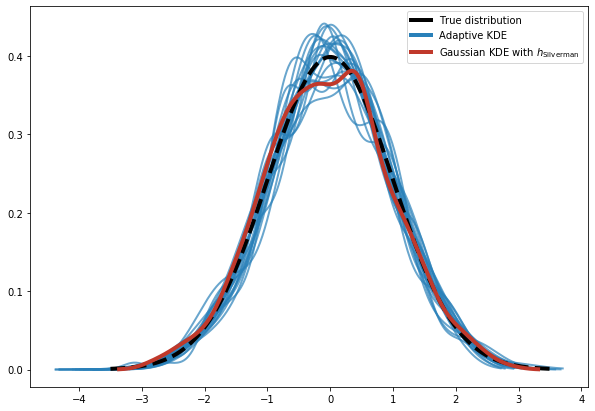

In [87]:
np.random.seed(1234)
colors = ["black", DARK_BLUE, DARK_RED]
labels = ["True distribution", "Adaptive KDE", r"Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

x_grid = np.linspace(-3.5, 3.5, 500)
for i in range(20):
    rvs = np.random.normal(size=1000)
    x_kde, y_kde = em_kde(rvs)
    plt.plot(x_kde, y_kde, linewidth=2, color=DARK_BLUE, alpha=0.7)
    
plt.plot(x_grid, stats.norm.pdf(x_grid), linewidth=4, linestyle="--", color="black")
x_kde, y_kde = convolution_kde(rvs)
plt.plot(x_kde, y_kde, linewidth=4, color=DARK_RED)   
plt.legend(lines, labels);

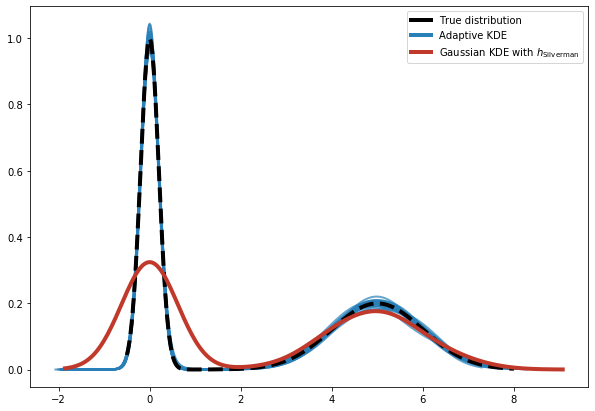

In [88]:
np.random.seed(1234)
mean = [0, 5]
sd = [0.2, 1]
n = 1000
x_grid = np.linspace(-0.5, 8, 1000)
pdf_true = get_pdf(x_grid, mean, sd)

colors = ["black", DARK_BLUE, DARK_RED]
labels = ["True distribution", "Adaptive KDE", r"Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

for i in range(20):
    rvs = generate_rvs(n, mean, sd)
    x_kde, y_kde = em_kde(rvs)
    plt.plot(x_kde, y_kde, linewidth=2, color=DARK_BLUE, alpha=0.7)
    
plt.plot(x_grid, pdf_true, linewidth=4, linestyle="--", color="black")
x_kde, y_kde = convolution_kde(rvs)
plt.plot(x_kde, y_kde, linewidth=4, color=DARK_RED)
plt.legend(lines, labels);

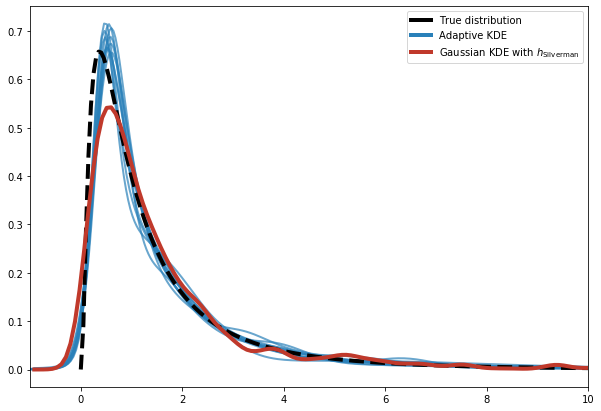

In [89]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
n = 1000

pdf_true = stats.lognorm.pdf(x_grid, s=1)

colors = ["black", DARK_BLUE, DARK_RED]
labels = ["True distribution", "Adaptive KDE", r"Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

for i in range(10):
    rvs = stats.lognorm.rvs(s=1, size=n)
    x_kde, y_kde = em_kde(rvs)
    plt.plot(x_kde, y_kde, linewidth=2, color=DARK_BLUE, alpha=0.7)
    
plt.plot(x_grid, pdf_true, linewidth=4, linestyle="--", color="black")
x_kde, y_kde = convolution_kde(rvs)
plt.plot(x_kde, y_kde, linewidth=4, color=DARK_RED)
plt.xlim(-1, 10)
plt.legend(lines, labels);

<center>
<strong> THIS SHOULD GO IN ANOTHER PLACE!! </strong>
</center>

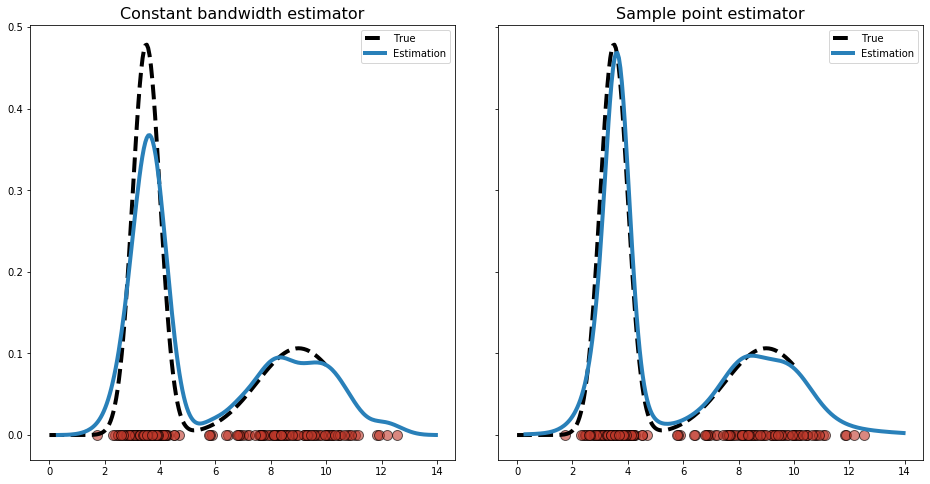

In [90]:
# This alternative goes in an appendix because it is not our topic yet.
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 9]
sd = [0.5, 1.5]
wt = [0.6, 0.4]
n = 200

rvs = generate_rvs(n, mean, sd, wt)
pdf_true = get_pdf(x_grid, mean, sd, wt)

hisj = h_isj(rvs)
hsil = h_sil(rvs)

h = (0.6 * hisj + 0.4 * hsil)
     
x1, y1 = convolution_kde(rvs, h=h)
x2, y2, h = gaussian_kde_adap(rvs, h=h)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

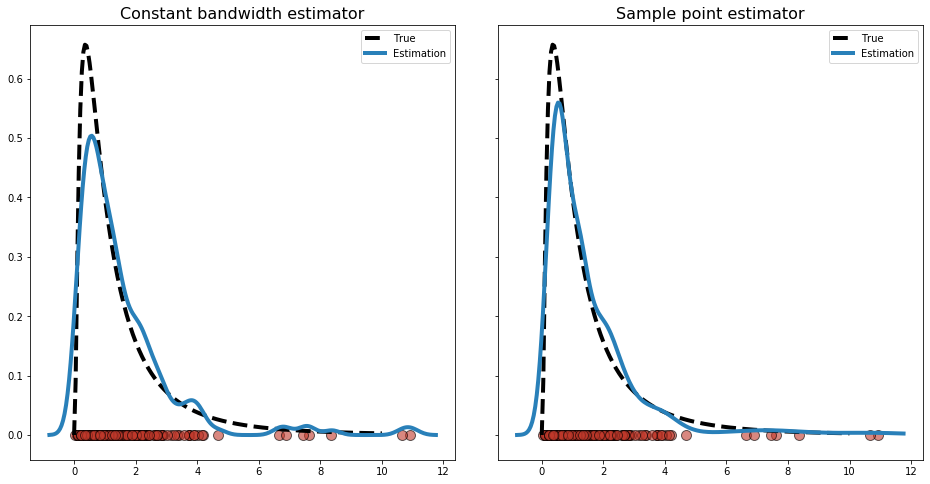

In [92]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 9]
sd = [0.5, 1.5]
wt = [0.6, 0.4]
n = 200

rvs = stats.lognorm.rvs(s=1, size=n)
pdf_true = stats.lognorm.pdf(x_grid, s=1)

hisj = h_isj(rvs)
hsil = h_sil(rvs)

h = (0.6 * hisj + 0.4 * hsil)

x1, y1 = convolution_kde(rvs, h=h)
x2, y2, h = gaussian_kde_adap(rvs, h=h)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)